In [84]:
import numpy as np
import pandas as pd
import os
import glob
import random
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.io import savemat
import mne
%matplotlib inline

### Load dataframe

In [132]:
nrem_dataframe = pd.read_csv('nrem_dataframe.csv')
len(nrem_dataframe)

1090

In [60]:
time_before_awakening = 60

nrem_dataframe["PSDS_60SEC_1TO50HZ"] = np.array(0).astype('object') #create object so arrays can be added

psds_list = []
for i in range(0,len(nrem_dataframe)):
    print(i)
    start_index = nrem_dataframe['PATH'][i].find('sub')
    nrem_dataframe.loc[i,'SHORT_PATH'] = nrem_dataframe['PATH'][i][start_index:]

    raw = mne.io.read_raw_eeglab('/data/tvanasse/nccam3/data/' + nrem_dataframe['PATH'][i][start_index:])

    psds, freqs = mne.time_frequency.psd_welch(raw,
                                               tmin = raw.times[-1]-time_before_awakening,
                                               tmax = raw.times[-1],
                                               fmin=1., fmax=50.,
                                               n_fft=2048,
                                               average='mean',
                                               n_overlap = 2048/2,
    #                                            n_jobs=15)
                                              )
    print(psds.shape)
    print(freqs.shape)
    nrem_dataframe.at[i,"PSDS_60SEC_1TO50HZ"] = psds.tolist()

nrem_dataframe.to_pickle("/data/tvanasse/nccam3/data/post_process_data/nrem_dataframe_psdextraction_" +\
                         str(time_before_awakening) +  "s.pkl")

0
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-5-cleaned2_nrem.fdt
Effective window size : 4.096 (s)
(185, 200)
(200,)
1
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-1-cleaned2_nrem.fdt
Effective window size : 4.096 (s)
(185, 200)
(200,)
2
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-9-cleaned2_nrem.fdt
Effective window size : 4.096 (s)
(185, 200)
(200,)
3
Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.fdt
Effective window size : 4.096 (s)
(185, 200)
(200,)
4


KeyboardInterrupt: 

In [142]:
time_before_awakening = 60

nrem_dataframe = pd.read_pickle("/data/tvanasse/nccam3/data/post_process_data/nrem_dataframe_psdextraction_" +\
                                str(time_before_awakening) + "s.pkl")

len(nrem_dataframe)

1090

In [143]:
# # ## Filter?
check = np.load('./sub_q1_data/sub_reportandnoreport.npy')
print(check)
nrem_dataframe = nrem_dataframe[nrem_dataframe.ID.isin(check)].reset_index(drop=True)
nrem_dataframe = nrem_dataframe[nrem_dataframe["Q1Experience"] != "Something"].reset_index(drop=True)
len(nrem_dataframe)

[2000 2004 2006 2008 2009 2010 2011 2012 2019 2020 2022 2023 2026 2027
 2028 2029 2030 2031 2032 2035 2037 2041 2047 2048 2049 2051 2052 2054
 2055 2058 2060 2061 2063 2064 2065 2066 2067 2068 2069 2070 2071 2073
 2075 2078 2080 2083 2084 2085 2087 2092 2097 2099 2101 2102 2103 2104
 2105 2106 2111 2121 2123 2126 2127 2128 2133 2134 2140 2142 2144]


588

In [144]:
# get band peaks
features_freqnorm = []
features_spatialnorm = []
features_absolute = []

for i in range(0,len(nrem_dataframe['PSDS_60SEC_1TO50HZ'].values)):
#     print(i)
    x = []
    y = []
    z = []
        
    for f in [[0,4],[4,8],[8,13],[13,30],[30,50]]:
        a = np.where(freqs >= f[0])
        b = np.where(freqs <= f[1])
        c = np.intersect1d(a,b)
    
        # Spatial Normalization
        x.append(stats.zscore(np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1)))
#         print(np.array(x).shape)
#         plt.plot(stats.zscore(np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1)))
#         plt.show()

        # Normalize PSD value by sum of all frequencies
        y.append(np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1)/np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,:], axis=1))
#         print(np.array(y).shape)
#         plt.plot(np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1)/np.sum(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,:], axis=1))
#         plt.show()    

        # Mean PSD across band (ABSOLUTE)
        z.append(np.mean(np.array(nrem_dataframe['PSDS_60SEC_1TO50HZ'][i])[:,c], axis=1))
    

    features_spatialnorm.append(np.array(x))
    features_freqnorm.append(np.array(y))
    features_absolute.append(np.array(z))
    
features_spatialnorm = np.array(features_spatialnorm)
features_freqnorm = np.array(features_freqnorm)
features_absolute = np.array(features_absolute)

### Save PSD data in mat form for snpm test

In [55]:
report_indices = nrem_dataframe[nrem_dataframe["Q1Experience"] == "Report"].index
something_indices = nrem_dataframe[nrem_dataframe["Q1Experience"] == "Something"].index
noreport_indices = nrem_dataframe[nrem_dataframe["Q1Experience"] == "NoReport"].index
reportsomething_indices = nrem_dataframe[nrem_dataframe["Q1Experience"] != "NoReport"].index

normtype = ["spatialnorm","freqnorm","absolute"]
normtype_i = 0
for norm_type in [features_spatialnorm, features_freqnorm, features_absolute]:
    
    q1report = ["report","something","noreport","reportsomething"]
    q1report_i = 0
    
    for report_type in [report_indices, something_indices, noreport_indices, reportsomething_indices]:
        mdic = {"delta": np.squeeze(norm_type[report_type,0,:]), 
                "theta": np.squeeze(norm_type[report_type,1,:]), 
                "alpha": np.squeeze(norm_type[report_type,2,:]), 
                "beta": np.squeeze(norm_type[report_type,3,:]), 
                "gamma": np.squeeze(norm_type[report_type,4,:])}
        savemat("/data/tvanasse/nccam3/data/post_process_data/psds/reportorsomethingandnoreport/" + q1report[q1report_i] + "_" + normtype[normtype_i] +\
                         str(time_before_awakening) + "s.mat", mdic)

        q1report_i = q1report_i + 1

    normtype_i = normtype_i + 1


### Save PSD data averaged across subjects

In [80]:
nrem_dataframe["ID_Visit"] = nrem_dataframe.ID.map(str) + "_" + nrem_dataframe.Visit.map(str)

In [83]:
norm_list = ["spatialnorm","freqnorm"]
norm_i = 0

for norm_type in [features_spatialnorm, features_freqnorm]:
#     print(norm_type)
    
    report_list = ["report","something","noreport","reportsomething"]
    report_i = 0
    for report_type in ["Report","Something","NoReport","reportsomething"]:
        print(report_type)
        
        delta = []
        theta = []
        alpha = []
        beta = []
        gamma = []
    
        for i in nrem_dataframe["ID"].unique():
            
    #         print(i)
            indices = nrem_dataframe[(nrem_dataframe["ID"] == i) &\
                                     (nrem_dataframe["Q1Experience"] == report_type)].index.values
        
            if report_type == "reportsomething":
                indices = nrem_dataframe[(nrem_dataframe["ID"] == i) &\
                             (nrem_dataframe["Q1Experience"] != "NoReport")].index.values
        
    #         print(indices)
            if indices.size != 0:
                delta.append(np.squeeze(np.mean(norm_type[indices,0,:],axis=0)))
                theta.append(np.squeeze(np.mean(norm_type[indices,1,:],axis=0)))
                alpha.append(np.squeeze(np.mean(norm_type[indices,2,:],axis=0)))
                beta.append(np.squeeze(np.mean(norm_type[indices,3,:],axis=0)))
                gamma.append(np.squeeze(np.mean(norm_type[indices,4,:],axis=0)))
        
#         print(len(delta))
#         print(np.vstack(delta).shape)
        mdic = {"delta": np.vstack(delta), 
                "theta": np.vstack(theta), 
                "alpha": np.vstack(alpha), 
                "beta": np.vstack(beta), 
                "gamma": np.vstack(gamma)}
        
        savemat("/data/tvanasse/nccam3/data/post_process_data/psds/reportandnoreport/" +\
                report_list[report_i] + "_" + norm_list[norm_i] + "_" +\
                         str(time_before_awakening) + "s_idavg.mat", mdic)
        
        report_i = report_i + 1
    
    norm_i = norm_i + 1

Report
NoReport
reportsomething
Report
NoReport
reportsomething


In [76]:
nrem_dataframe["ID"].unique()

array([2000, 2004, 2006, 2008, 2009, 2010, 2011, 2012, 2019, 2020, 2022,
       2023, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2035, 2037, 2041,
       2047, 2048, 2049, 2051, 2052, 2054, 2055, 2058, 2060, 2061, 2063,
       2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2073, 2075, 2078,
       2080, 2083, 2084, 2085, 2087, 2092, 2097, 2099, 2101, 2102, 2103,
       2104, 2105, 2106, 2111, 2121, 2123, 2126, 2127, 2128, 2133, 2134,
       2140, 2142, 2144])

In [61]:
print("/data/tvanasse/nccam3/data/post_process_data/psds/" +\
                report_list[report_i] + "_" + norm_list[norm_i])

IndexError: list index out of range

### Run statistics

0.23.0
Reading /data/tvanasse/nccam3/data/sub-2001/eeg/ses-3/awakening-1-cleaned2_nrem.fdt


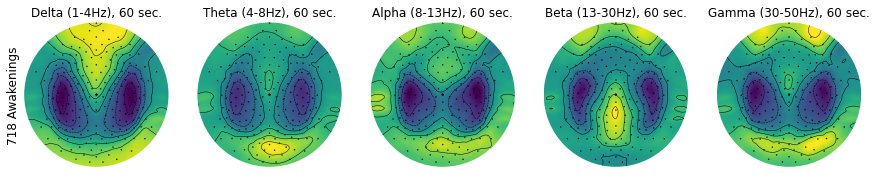

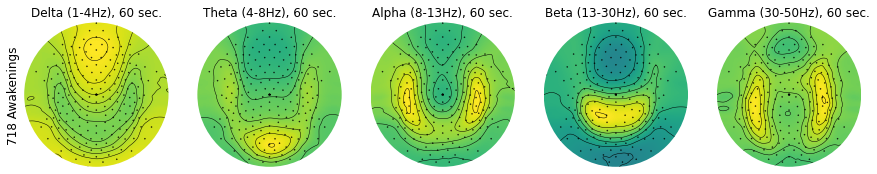

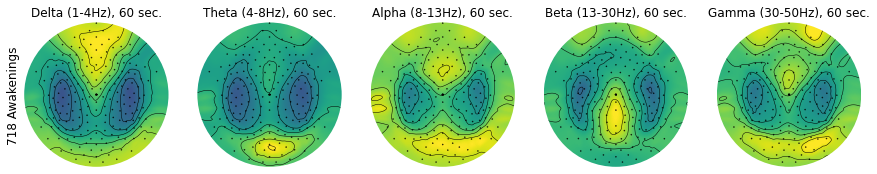

In [323]:
from matplotlib import cm, colors, colorbar
%matplotlib inline

# nrem_dataframe = nrem_dataframe[nrem_dataframe["Q1Experience"] != "Something"].reset_index(drop=True)

print(mne.__version__)
raw = mne.io.read_raw_eeglab(data_folder + 'sub-2001/eeg/ses-3/awakening-1-cleaned2_nrem.set')
# Plot the topography of ranking

# p_threshold = 0.005
for ar in [features_spatialnorm, features_freqnorm, features_absolute]:
    fig, axs = plt.subplots(1,5, figsize=(15,5))

    timerange = 60
    titles = ["Delta (1-4Hz), " + str(timerange) + " sec.",
              "Theta (4-8Hz), " + str(timerange) + " sec.",
              "Alpha (8-13Hz), " + str(timerange) + " sec.",
              "Beta (13-30Hz), " + str(timerange) + " sec.",
              "Gamma (30-50Hz), " + str(timerange) + " sec."]
    
    for row in range(0,1):
        for j in range(0,5):      
    #         sig_mask = np.array(psd_avg_vals[j]) < p_threshold
            measure = np.mean(ar[:,j,:],axis=0)
    #         vmin, vmax = -5,5
            cmap = cm.viridis

            mne.viz.plot_topomap(measure, 
                                 pos=raw.info, 
    #                              outlines='skirt',
    #                              mask=sig_mask,
    #                              vmin=np.min(measure), 
    #                              vmax=np.max(measure), 
                                 show=False,
                                 axes=axs[j],
                                 cmap=cmap,
                                 res=150,
    #                              cbar_fmt='-%0.1f',
                                 )
            if row == 0:
                axs[j].set_title(titles[j])
            if (j == 0) and (row == 0):
                axs[j].set_ylabel(str(len(ar)) + ' Awakenings', size='large')

### Run LME test

In [135]:
nrem_dataframe["REPORT_BINARY"] = "No Experience"
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"REPORT_BINARY"] = "Conscious Experience"


norm_list_p_stats = []
norm_list_t_stats = []

# for ar in [features_spatialnorm, features_freqnorm, features_absolute]:
for ar in [features_freqnorm]:
    psd_p_vals = []
    psd_t_vals = []

    for eegrange in range(0,5):
        print("bin range calculation (of 5): " + str(eegrange))
        p_vals = []
        t_vals = []
        
        for chan in range(0,185):
            nrem_dataframe["y"] = ar[:,eegrange,chan]
            nrem_dataframe["Q1_DUMMY"] = 0
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["REPORT_BINARY"] == "Conscious Experience"].index,"Q1_DUMMY"] = 1

    #         model with nested variance component
    #         vc = {'Visit': '0 + C(Visit)'}
    #         md = sm.MixedLM.from_formula('y ~ Q1_DUMMY', 
    #                                      vc_formula=vc,                                   
    #                                      re_formula='1', 
    #                                      groups='ID', 
    #                                      data=nrem_dataframe)
    #         mdf = md.fit()

            # no nested variance component for visit
            md = smf.mixedlm('y ~ Q1_DUMMY', nrem_dataframe, groups=nrem_dataframe["ID"])
            mdf = md.fit()

        #     print(mdf.summary())
            p_vals.append(mdf.pvalues['Q1_DUMMY'])
            t_vals.append(mdf.tvalues['Q1_DUMMY'])

        psd_p_vals.append(np.array(p_vals))
        psd_t_vals.append(np.array(t_vals))
    
    norm_list_p_stats.append(psd_p_vals)
    norm_list_t_stats.append(psd_t_vals)

bin range calculation (of 5): 0


KeyboardInterrupt: 

In [ ]:
len(nrem_dataframe)

In [ ]:
# np.save("/data/tvanasse/nccam3/data/post_process_data/something_vs_noreport_pstats.mat",
#        norm_list_p_stats)
# np.save("/data/tvanasse/nccam3/data/post_process_data/something_vs_noreport_tstats.mat",
#        norm_list_t_stats)

In [ ]:
from matplotlib import cm, colors, colorbar
%matplotlib inline

data_folder = '/data/tvanasse/nccam3/data/'

print(mne.__version__)
raw = mne.io.read_raw_eeglab(data_folder + 'sub-2000/eeg/ses-1/awakening-7-cleaned2_nrem.set')

## ONLY FOR PLOTTING, MNE reads positions as meters
for i in range(len(raw.info['chs'])):
    raw.info['chs'][i]['loc'] = raw.info['chs'][i]['loc']/100

for norm in range(0,1):
    if norm == 0:
        print("Spatial PSD Normalization")
    elif norm == 1:
        print("Frequency PSD Normalization")
    elif norm == 2:
        print("Aboslute PSD")

    fig, axs = plt.subplots(2,5, figsize=(15,5))

    timerange = 1
    titles = ["Delta (1-4Hz), " + str(time_before_awakening) + " sec.",
              "Theta (4-8Hz), " + str(time_before_awakening) + " sec.",
              "Alpha (8-13Hz), " + str(time_before_awakening) + " sec.",
              "Beta (13-30Hz), " + str(time_before_awakening) + " sec.",
              "Gamma (30-50Hz), " + str(time_before_awakening) + " sec."]

    p_threshold = 0.005
    for row in range(0,2):
        for j in range(0,5):
            if row == 0:
                sig_mask = np.array(norm_list_p_stats[norm][j]) < p_threshold
                measure = np.array(-1*np.log(norm_list_p_stats[norm][j]))
                vmin, vmax = 2.0, 6
                cmap = cm.viridis
            elif row == 1:
                sig_mask = np.array(norm_list_p_stats[norm][j]) < p_threshold
                measure = np.array(norm_list_t_stats[norm][j])
                vmin, vmax = -5,5
                cmap = cm.bwr
                
            mne.viz.plot_topomap(measure, 
                                 pos=raw.info, 
    #                              outlines='skirt',
                                 mask=sig_mask,
                                 vmin=vmin, 
                                 vmax=vmax, 
                                 show=False,
                                 axes=axs[row,j],
                                 cmap=cmap,
                                 res=150,
    #                              cbar_fmt='-%0.1f',
                                 )
#             if row == 0:
            axs[row,j].set_title(titles[j])
            if (j == 0) and (row == 0):
                axs[row,j].set_ylabel('-LOG(P)', size='large')
            if (j == 0) and (row == 1):
                axs[row,j].set_ylabel('T-Stat (Report - NoReport)', size='large')

In [115]:
len(nrem_dataframe)

618

### Parcels

In [137]:
start_index = nrem_dataframe['PATH'][0].find('sub')
raw = mne.io.read_raw_eeglab(data_folder + nrem_dataframe['PATH'][0][start_index:])

# # fig, axs = plt.subplots(figsize=(20,20))
# raw.plot_sensors(ch_type='eeg', 
#                  show_names=True, 
# #                  ch_groups='position',
# #                  axes=axs,
#                  to_sphere=True)

Reading /data/tvanasse/nccam3/data/sub-2000/eeg/ses-1/awakening-5-cleaned2_nrem.fdt


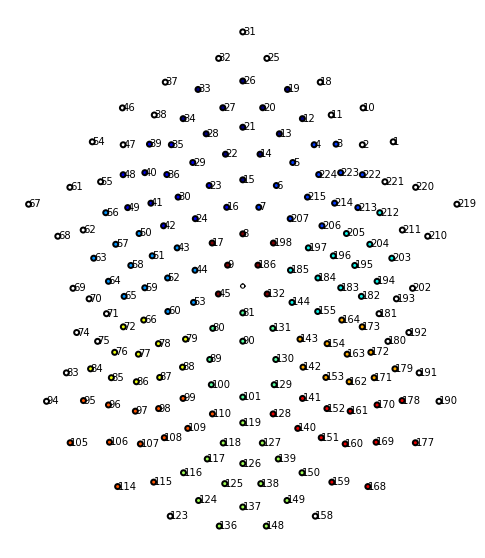

In [138]:
hist_bins = [["26","27","20","21","28","15","22","14","13","34","33","12","19"],
             
             ["16","23","29","35","36","30","24","42","41","49","48","40","39"],
             
             ["7","6","5","4","3","224","215","207","214","213","222","206","39","223"],
             
             ["56","63","57","44","43","53","52","51","60","59","58","65","64","50"],
             
             ["212","205","203","204","144","185","197","155","184","196","195","183","182","194"],
             
             ["81","80","131","130","129","101","100","89","90"],
             
             ["119","118","117","126","139","127","125","138","137","116","124","149","150","136","148"],
             
             ["79","78","77","88","87","86","85","76","72","66","84",],
             
             ["143","154","163","142","153","162","164","173","172","171","179"],
             
             ["110","99","109","108","98","97","107","115","114","106","96","95","105"],
             
             ["128","141","140","151","152","161","160","159","169","168","170","178","177"],
             
             ["8","17","9","45","132","186","198"]
             ]

groups = []
for ch_names in hist_bins:
    indices = [raw.ch_names.index(ch_name) for ch_name in ch_names]
    groups.append(indices)
    
fig, axs = plt.subplots(figsize=(10,10))
mne.viz.plot_sensors(raw.info, 
                     ch_groups=groups, 
                     axes=axs,
                     show_names=True)

fig.savefig("test.png", dpi=400)

In [139]:
import scipy.io as sio
inside185ch = sio.loadmat('../channel_location_file/inside185ch.mat')

#256 labels/indices
parcels_256labels = {"Frontal_Central": np.array(list(map(int,hist_bins[0]))),
     "Frontal_Left": np.array(list(map(int,hist_bins[1]))),
     "Frontal_Right": np.array(list(map(int,hist_bins[2]))),
     "Temporal_Left": np.array(list(map(int,hist_bins[3]))),
     "Temporal_Right": np.array(list(map(int,hist_bins[4]))),
     "Parietal_Central": np.array(list(map(int,hist_bins[5]))),
     "Occipital_Central": np.array(list(map(int,hist_bins[6]))),
     "Parietal_Left":np.array(list(map(int,hist_bins[7]))),
     "Parietal_Right":np.array(list(map(int,hist_bins[8]))),
     "Occipital_Left":np.array(list(map(int,hist_bins[9]))),
     "Occipital_Right":np.array(list(map(int,hist_bins[10]))),
     "Central":np.array(list(map(int,hist_bins[10])))
     }

#256 labels to 185indices
parcels_185indices = {}

for parcel in list(parcels_256labels.keys()):
    translate = []
    
    for i in range(0,len(parcels_256labels[parcel])):
        translate.append(np.where(np.squeeze(inside185ch['inside185ch']) == parcels_256labels[parcel][i])[0][0])
    
    parcels_185indices.update({parcel:np.array(list(map(int,translate)))})

In [140]:
# time_before_awakening = 30

# nrem_dataframe = pd.read_pickle("/data/tvanasse/nccam3/data/post_process_data/nrem_dataframe_psdextraction_" +\
#                                 str(time_before_awakening) + "s.pkl")


In [147]:
import warnings
warnings.filterwarnings('ignore')
nrem_dataframe["ID_Visit"] = nrem_dataframe.ID.map(str) + "_" + nrem_dataframe.Visit.map(str)

nrem_dataframe["REPORT_BINARY"] = "No Experience"
nrem_dataframe.loc[nrem_dataframe[(nrem_dataframe["Q1Experience"] != "NoReport")].index,"REPORT_BINARY"] = "Conscious Experience"

print(len(nrem_dataframe))

titles = ["Delta (1-4Hz), " + str(time_before_awakening) + " sec.",
          "Theta (4-8Hz), " + str(time_before_awakening) + " sec.",
          "Alpha (8-13Hz), " + str(time_before_awakening) + " sec.",
          "Beta (13-30Hz), " + str(time_before_awakening) + " sec.",
          "Gamma (30-50Hz), " + str(time_before_awakening) + " sec."]


norm_list_p_stats = []
norm_list_t_stats = []

for ar in [features_freqnorm]:
    psd_p_vals = []
    psd_t_vals = []

    for eegrange in range(0,5):
        print("bin range calculation (of 5): " + str(eegrange))
        p_vals = []
        t_vals = []
        
        for parcel in list(parcels_185indices.keys()):
            #take mean across channels
            nrem_dataframe["y"] = np.mean(ar[:,eegrange,parcels_185indices[parcel]],axis=1)
            
            nrem_dataframe["Q1_DUMMY"] = 0
            nrem_dataframe.loc[nrem_dataframe[nrem_dataframe["REPORT_BINARY"] == "Conscious Experience"].index,"Q1_DUMMY"] = 1

# #             model with nested variance component
#             vc = {'Visit': '0 + C(Visit)'}
#             md = sm.MixedLM.from_formula('y ~ Q1_DUMMY', 
#                                          vc_formula=vc,                                   
#                                          re_formula='1', 
#                                          groups='ID', 
#                                          data=nrem_dataframe)
#             mdf = md.fit()

            # no nested variance component for visit
            md = smf.mixedlm('y ~ Q1_DUMMY', 
                             nrem_dataframe, 
                             groups=nrem_dataframe["ID"])
            mdf = md.fit()

            if mdf.pvalues['Q1_DUMMY'] < 0.05/12:
                print(parcel + ", ")
#                 print(titles[eegrange])
#                 print("corrected pvalue: " + str(float(mdf.pvalues['Q1_DUMMY']*11)))
#                 print("t-value: " + str(float(mdf.tvalues['Q1_DUMMY'])) + "\n")

            p_vals.append(mdf.pvalues['Q1_DUMMY'])
            t_vals.append(mdf.tvalues['Q1_DUMMY'])

        psd_p_vals.append(np.array(p_vals))
        psd_t_vals.append(np.array(t_vals))
    
    norm_list_p_stats.append(psd_p_vals)
    norm_list_t_stats.append(psd_t_vals)

588
bin range calculation (of 5): 0
bin range calculation (of 5): 1
bin range calculation (of 5): 2
bin range calculation (of 5): 3
bin range calculation (of 5): 4
Temporal_Left, 
Occipital_Central, 


In [123]:
len(nrem_dataframe)

618